# Levana Flipside Analysis - 
## Questions
### 1. Meteor Shower Participants
For those who bought and participated in the Levana Meteor Shower, is there a relationship between their participation and their LUNATIC degen score?
### 2. Free Square
Provide any interesting insights on Levana. These will be judged by a council that includes other community members and the Flipside team! 

## Data
### Meteor Shower Participants
I used flipside crypto data platform to extract the participants in the levana meteor shower. Thanks to *massnomis.eth#7291* on flipside's discord for providing the smart contract address `terra1dax9mddsycvzkc429wwy494vhzhggw3d5594rt`. I found the wallets that sent UST by interacting with that address from 7-10 November.
You can view the SQL code on my published [flipside crypto dashboard](https://app.flipsidecrypto.com/dashboard/levana-meteor-shower-OcjwUc).

### LUNATIC degen score
I downloaded the data from the [LUNAtic ranking dashboard](https://science.flipsidecrypto.com/lunatics/) making sure to select all the degen scores on the slider.

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
# Load the data
df = pd.read_csv('levana-donations.csv')
df.columns = ['wallet', 'levana_interactions', 'levana_ust']
df_degen = pd.read_csv('degen-scores.csv')
df = df.merge(df_degen, how='inner', left_on='wallet', right_on='address')
df = df.drop(columns = ['Unnamed: 0', 'address'])

## Statistics from meteor event

In [3]:
print("Number of wallets taking part:", df.shape[0])

Number of wallets taking part: 6340


In [4]:
print("Number of interactions per wallet:", round(df.levana_interactions.sum()/df.shape[0],1))

Number of interactions per wallet: 7.9


To get all the dragons eggs you would have to interact 44 times, once per hour for 44 hours

In [5]:
print("Percent of wallets interacting only once:", round(df[df.levana_interactions==1].shape[0]/df.shape[0]*100,1), "%")

Percent of wallets interacting only once: 25.6 %


In [6]:
print("Total raised:", round(df.levana_ust.sum()/1e6,2), "Million UST")

Total raised: 3.98 Million UST


In [7]:
print("Average UST given:", round(df.levana_ust.mean(),2))

Average UST given: 627.88


A few very large contributes skew the average.

In [8]:
print("Median UST given:", round(df.levana_ust.median(),2))

Median UST given: 100.0


In [9]:
# Percentiles
percentiles = np.arange(10,100, step=10)
res = np.percentile(df.levana_ust, percentiles)
for ix, value in enumerate(percentiles):
    print("Top", 100-value, "%", "of wallets spent", round(res[ix],2), "UST or more")

Top 90 % of wallets spent 8.0 UST or more
Top 80 % of wallets spent 19.0 UST or more
Top 70 % of wallets spent 36.0 UST or more
Top 60 % of wallets spent 60.0 UST or more
Top 50 % of wallets spent 100.0 UST or more
Top 40 % of wallets spent 173.0 UST or more
Top 30 % of wallets spent 264.3 UST or more
Top 20 % of wallets spent 455.0 UST or more
Top 10 % of wallets spent 1066.66 UST or more


### Distribution plot of amount spent per wallet
A log scale has to be used to visualise the data. The majority give the minimum of \\$8. Then there is a second peak who give around \\$250. Then there is a long tail with donations going up to 10's of thousands

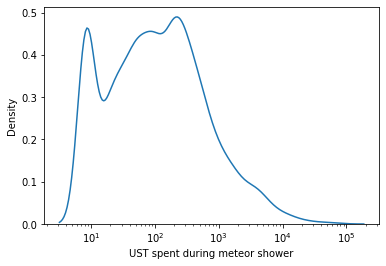

In [10]:
plt = sns.kdeplot(data=df, x='levana_ust', log_scale=True)
plt = plt.set(xlabel = "UST spent during meteor shower")
# plt.xlabel = "UST given during meteor shower"
# plt.show()

## Correlation with Crypto degen score
Plot the degen score vs the amount spent in the meteor shower event

<AxesSubplot:xlabel='Degen Score', ylabel='Average UST Spent'>

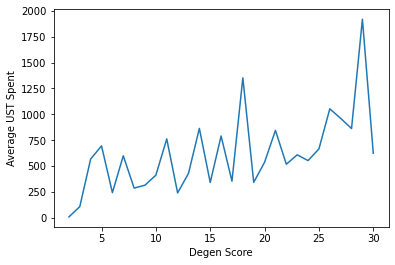

In [11]:
df.groupby("Total Score")['levana_ust'].agg("mean").sort_index().plot(xlabel="Degen Score", ylabel="Average UST Spent")

The graph shows that on average users with a higher degen score spent more money.

In [12]:
# What is the correlation score?
c = round(np.corrcoef(df.levana_ust, df["Total Score"])[0,1],3)
print("Correlation Coefficient:", c)

Correlation Coefficient: 0.059


Correlation coefficient also supports there is a correlation between Degen Score and UST spent. The correlation is quite weak. 0 is no correlation and 1 is complete identical correlation. The outliers who spent a lot of money are probably the cause of causing the low correlation coefficient (as well as the degen score being integer values as opposed to a continous scale)

### Use machine learning to drill down further
The degen score is made up of a number of features such as number of airdrops claimed, number of DEX trades... Which of these individual features are most helpful in identifying a user that will invest a significant amount during the meteor shower. The results could be useful for planning future events.

I consider a signifcant amoutn as $500 which accounts for the top 20% of wallets. The model used is random forests and the imprtance features will be used. 



In [13]:
df["Spent over $500"] = df["levana_ust"] > 500
res = df.groupby("Spent over $500", as_index=False)["Total Score"].agg("mean")
res.rename(columns={"Total Score": "Average Degen Score"}, inplace=True)

print(res.round(2).to_string(index=False))

 Spent over $500  Average Degen Score
           False                15.89
            True                17.71


In [14]:
# Prepare and List the features
y = df["Spent over $500"].astype(int)
X = df[["n_governance_votes", "n_airdrop_and_gov_stakes", "n_projects_staked", "n_airdrops_claimed",
       "n_protocols_claimed", "repeat_protocol_claims", "n_dex_trades", "n_tokens_used", "n_lp_deposits",
       "n_transactions", "days_since_last_txn", "n_contracts", "net_from_shuttle_cex", "prop_luna_staked",
       "prop_drops_kept"]]
features = X.columns.values
print("List of the features:")
print("--------------")
for f in features:
    print(f)

List of the features:
--------------
n_governance_votes
n_airdrop_and_gov_stakes
n_projects_staked
n_airdrops_claimed
n_protocols_claimed
repeat_protocol_claims
n_dex_trades
n_tokens_used
n_lp_deposits
n_transactions
days_since_last_txn
n_contracts
net_from_shuttle_cex
prop_luna_staked
prop_drops_kept


In [15]:
X = StandardScaler().fit_transform(X)
rf = RandomForestClassifier(n_jobs=-1, random_state=12345)
# Do a smallish grid search
parameters = {
    "criterion": ["gini", "entropy"],
    "max_depth": [13,14,15],
    "max_features": [3,4,5],
}
clf = GridSearchCV(rf, parameters, scoring='f1')
# Train the model. Takes a couple of minutes
clf.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [13, 14, 15], 'max_features': [3, 4, 5]},
             scoring='f1')

In [16]:
# The best parameters chosen
clf.best_params_

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 4}

In [17]:
# F1 score of the model
clf.best_score_

0.035343836187633246

In [18]:
# Accuracy of the model. Its an easier metric to understand
model = clf.best_estimator_
predictions = model.predict(X)
accuracy = accuracy_score(y, predictions)
print("Model accuracy is:", round(accuracy*100,1), "%")

Model accuracy is: 82.2 %


### Insights from the model
Start by listing the features in order of how important they are in predicting if a user spent over $500. A higher importance means it is more useful to the model for prediction

In [19]:
importances = pd.DataFrame({
    "feature": features,
    "importance": model.feature_importances_,})
importances = importances.sort_values("importance", ascending=False)
importances["importance"] = importances["importance"]/importances["importance"].sum()*100
importances = importances.reset_index(drop=True)
importances

,feature,importance
0,prop_luna_staked,11.506207
1,net_from_shuttle_cex,10.609645
2,n_governance_votes,9.845951
3,prop_drops_kept,9.726060
4,n_projects_staked,9.340599
5,n_lp_deposits,9.081855
6,n_transactions,8.564296
7,n_airdrop_and_gov_stakes,6.208521
8,repeat_protocol_claims,5.771841
9,n_protocols_claimed,5.364100


There is no major stand-out feature driving the model. (Note these features were extracted after the meteor shower. If there was time we would go back and edit the corresponging flipside SQL  to take a snapshot before the meteor shower). The meaning of these features are explained at the bottom of the [LUNATIC degen dashboard](https://science.flipsidecrypto.com/lunatics/)

Lets investiage the top two important features to get an idea of the insights the model picked up.

The feature `prop_luna_staked` refers to the wallet having 75% or more luna currently staked. It gives a score of 2 if true.

In [20]:
df["75% of LUNA is staked"] = df["prop_luna_staked"] == 2
res = df.groupby("75% of LUNA is staked", as_index=False)["Spent over $500"].agg("mean")
print(res.round(2).to_string(index=False))

 75% of LUNA is staked  Spent over $500
                 False             0.19
                  True             0.18


People spending more than $500 on the meteor show are slightly less likely to have 75% or more of their LUNA staked

The feature `net_from_shuttle_cex` is 1 if the wallet has recieved more from Bridges and CEX's than they have sent

In [21]:
res = df.groupby("net_from_shuttle_cex", as_index=False)["Spent over $500"].agg("mean")
print(res.round(2).to_string(index=False))

 net_from_shuttle_cex  Spent over $500
                    0             0.24
                    1             0.17


Those spending more than $500 on the meteor shower are more likely to be sending money off the Terra chain in the last 90 days